# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если клиент собирается уйти, ему будет предложен промокод и специальные условия. Есть персональные данные, информация о тарифах и договорах некоторых клиентов.

Цель: необходимо построить модель, которая спрогнозирует уход клиента в ближайшее время.

# План работы:

1. Изучение общей информации о данных
2. Предобработка данных
   - 2.1 Объединение датасетов
   - 2.2 Работа с типами данных
   - 2.3 Обработка пропусков
   - 2.4 Создание дополнительных признаков
3. Исследовательский анализ
   - 3.1 Изучение факторов влияния на отток клиентов
   - 3.2 Взаимосвязь признаков
4. Обучение моделей
   - 4.1 Выделение выборок
   - 4.2 Кодирование данных
   - 4.3 Обучение моделей   
5. Тестирование лучшей модели

В данном проекте решается задача классификации.

## Изучение общей информации о данных

Загрузим необходимые библиотеки и датасеты

In [ ]:
!pip install phik
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01     |█████████████████████████       | 24.0 MB 1.1 MB/s eta 0:00:07
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [ ]:
RANDOM_STATE = 310723
data_load = '2020-02-01'

In [ ]:
data_contract = pd.read_csv('/datasets/contract_new.csv')
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

Изучим общую информацию о данных

In [ ]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Определили, что поле customerID присутствует здесь и в других датасетах для связки клиентов между таблицами БД. Видим, что в данном наборе данных нет пропусков и последний столбец почему-то относится к типу данных object, хотя на первый взгляд в нём отображены числовые данные

In [ ]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Здесь тоже нет пропусков, количество строк такое же, как и в предыдущем наборе, и на первый взгляд все столбцы являются бинарными категориальными признаками

In [ ]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Данных по пользователям интернетом меньше, чем в двух первых наборах. Это логично, кто-то из клиентов не пользуется интернетом. Признаки датасета являются бинарными категориальными

In [ ]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В данном наборе данных один бинарный категориальный признак: подключены у клиента несколько телефонных линий или нет. Данных так же меньше, чем в первых двух датасетах

Вывод: после первичного изучения данных мы выяснили, что есть 2 датасета, объединяющих всех клиентов, и 2, разделяющих клиентов по услугам пользования интернетом и телефоном. Из-за разделения по услугам количество строк отличается, а значит после объединения данных появятся пропуски, которые необходимо обработать. В основном в датасетах присутствуют бинарные категориальные признаки, но есть и количественные

## Предобработка данных

### Объединение датасетов

Для того чтобы наша будущая модель могла прогнозировать отток клиентов необходимо объединить данные датафреймов, так как в разрозненном виде они не дадут нужного результата

In [ ]:
data = data_contract.merge(data_personal, on='customerID', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 715.3+ KB


Мы использовали метод слияния inner, так как в первых двух датафреймах одинаковое количество строк с уникальными идентификаторами клиентов

In [ ]:
data = data.merge(data_internet, on='customerID', how='left')
data = data.merge(data_phone, on='customerID', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Данные по пользователям интернетом и телефоном мы присоединили левым типом, так как нам нужно сохранить все строки. Проверим, как выглядит датасет теперь

In [ ]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Посмотрим, сколько у нас уникальных идентификаторов клиентов и нет ли дубликатов

In [ ]:
data['customerID'].value_counts()

7916-VCCPB    1
5519-TEEUH    1
7077-XJMET    1
2371-KFUOG    1
3606-TWKGI    1
             ..
4236-XPXAV    1
2720-WGKHP    1
0320-JDNQG    1
0835-JKADZ    1
6897-UUBNU    1
Name: customerID, Length: 7043, dtype: int64

Таким образом, мы объединили наши данные, не потеряв ни одного клиента, и можем приступить к дальнейшей предобработке

### Работа с типами данных

Вернёмся к вопросу с типом данных. В первой части у нас возникло сомнение, что в столбце TotalCharges должны быть объекты типа "object", так как в нём отображаются числа. Изменим тип данных на вещественные числа. Если в столбце будут появляться неподходящие значения, они станут пропусками

In [ ]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

Посмотрим, появились ли пропуски

In [ ]:
data['TotalCharges'].isna().sum()

11

Видим, что появились пропущенные значения, а значит далее мы можем поработать с ними и с другими пропусками в данных

### Обработка пропусков

Обработаем 11 строк с пропусками из предыдущего подпункта. Так как числовых признаков не так много в наборе данных, они будут достаточно сильно влиять на прогноз модели. Это означает, что усреднять данные для этих пропусков - в целом не лучшая идея, потому что мы начнём терять их объективность. Предположим, что пустые значения появились в столбце неспроста и означают то, что клиент просто ещё ничего не платил. Поэтому мы можем заполнить пропуски нулевым значением

In [ ]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)
data['TotalCharges'].isna().sum()

0

Посмотрим, в каких столбцах и сколько пропусков

In [ ]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Так как клиенты в нашем датасете все уникальные, мы можем утверждать, что 1526 человек не пользуются интернетом, а 682 - телефоном. Для корректного последующего анализа данных мы можем так и обозначить эти пропуски

In [ ]:
int_features_list = data_internet.columns.to_list()
for feature in int_features_list:
    data[feature] = data[feature].fillna('no_internet')

data['MultipleLines'] = data['MultipleLines'].fillna('no_phone')

data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [ ]:
data.tail(6)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1553.26,Female,0,No,No,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,no_phone
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


Видим, что заглушки на месте

### Создание дополнительных признаков

Для того, чтобы решить задачу классификации клиентов, нужно выделить целевой признак. В нашем случае подходит признак окончания контракта. Если контракт не окончен, присваиваем ему 0 - клиент не ушёл. Если же дата окончания есть, значит присваем 1 - клиент ушёл

In [ ]:
data['Gone'] = data['EndDate']

for value in list(data['Gone'].unique()):
    if value != 'No':
        data['Gone'] = data['Gone'].replace(value, 1)

data['Gone'] = data['Gone'].replace('No', 0)
data['Gone'].value_counts()

0    5942
1    1101
Name: Gone, dtype: int64

Добавим ещё один признак, который поможет модели лучше определить класс пользователя. Выделим количество дней действия контракта каждого клиента. Для этого вычтем из даты окончания контракта дату начала. Если даты окончания нет, заменим её на дату выгрузки данных

In [ ]:
data['EndDate'] = data['EndDate'].replace('No', data_load)
data['EndDate'].value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2014-09-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

In [ ]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y.%m.%d')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y.%m.%d')

data['ContractDuration'] = (data['EndDate'] - data['BeginDate']).dt.days
data['ContractDuration'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: ContractDuration, dtype: int64

Теперь нам необходимо удалить признаки начала и конца действия контракта, так как они могут привести к утечке данных и модель переобучится

In [ ]:
data = data.drop(['EndDate', 'BeginDate'], axis=1)

Перед аналитическим блоком установим уникальный номер пользователя как индекс

In [ ]:
data = data.set_index('customerID')
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Gone,ContractDuration
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Вывод: в этом разделе мы объединили наши данные в общий датафрейм, починили типы данных, обработали пропуски и выделили целевой признак, а также добавили дополнительный для лучшего обучения моделей. Теперь приступим к исследовательскому анализу, который поможет лучше раскрыть имеющиеся данные

## Исследовательский анализ

### Изучение факторов влияния на отток клиентов

Оценим признаки, представленные числами, с точки зрения целевого. Сначала посмотрим, как в целом выглядят распределения данных

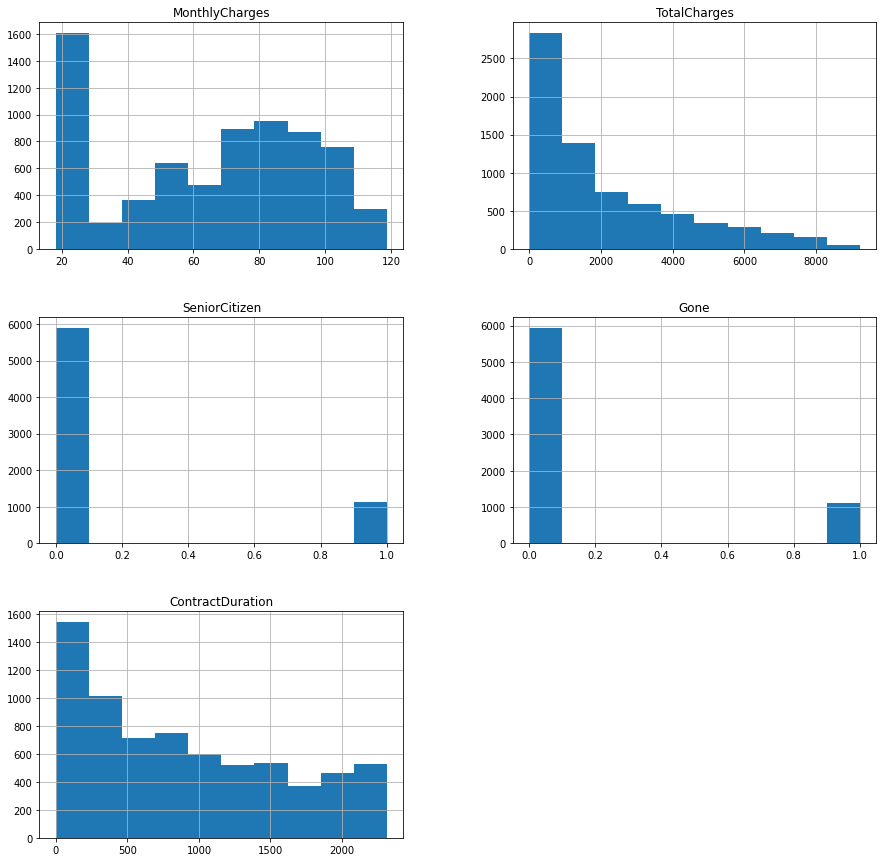

In [ ]:
data.hist(figsize=(15, 15));

Видим, что распределения вполне корректные. Выглядит интересно, что распределение целевого признака и признака Пенсионер очень похожи.

Теперь оставим выборку только активных пользователей и построим такие же гистограммы

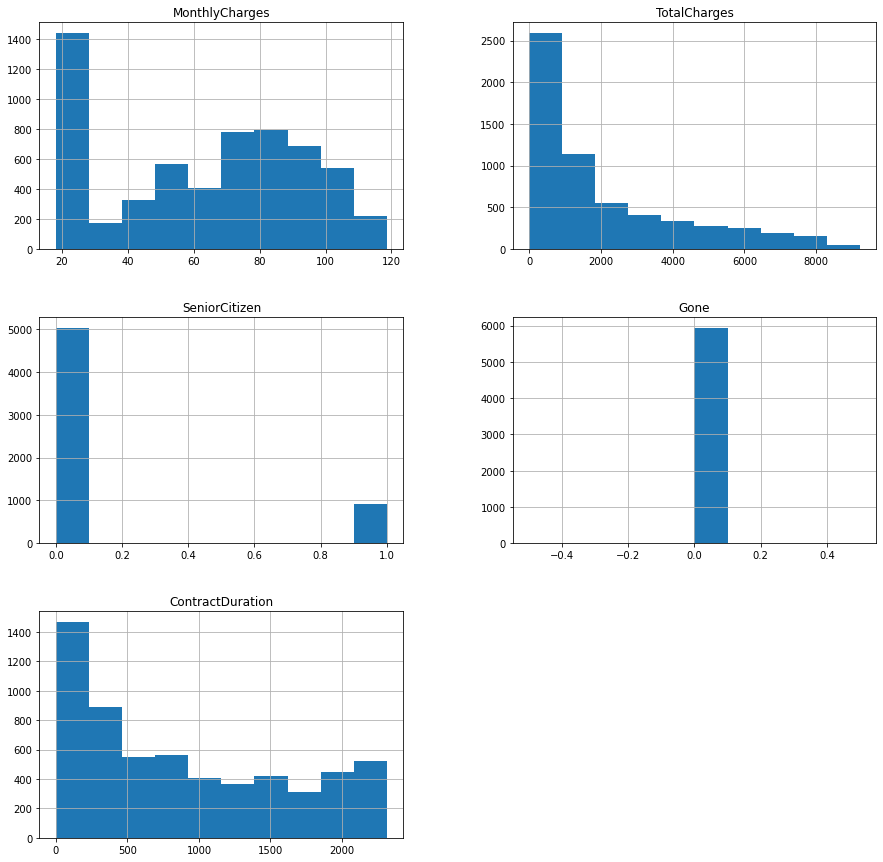

In [ ]:
data_active = data.query('Gone == 0')
data_active.hist(figsize=(15, 15));

На графиках мало что изменилось. Это логично, ведь большую часть данных составляют именно действующие клиенты, и то, что на этих графиках не произошло значимых изменений говорит о разнородности ушедших клиентов.

Лучше составить их портрет поможет выделение выборки ушедших пользователей

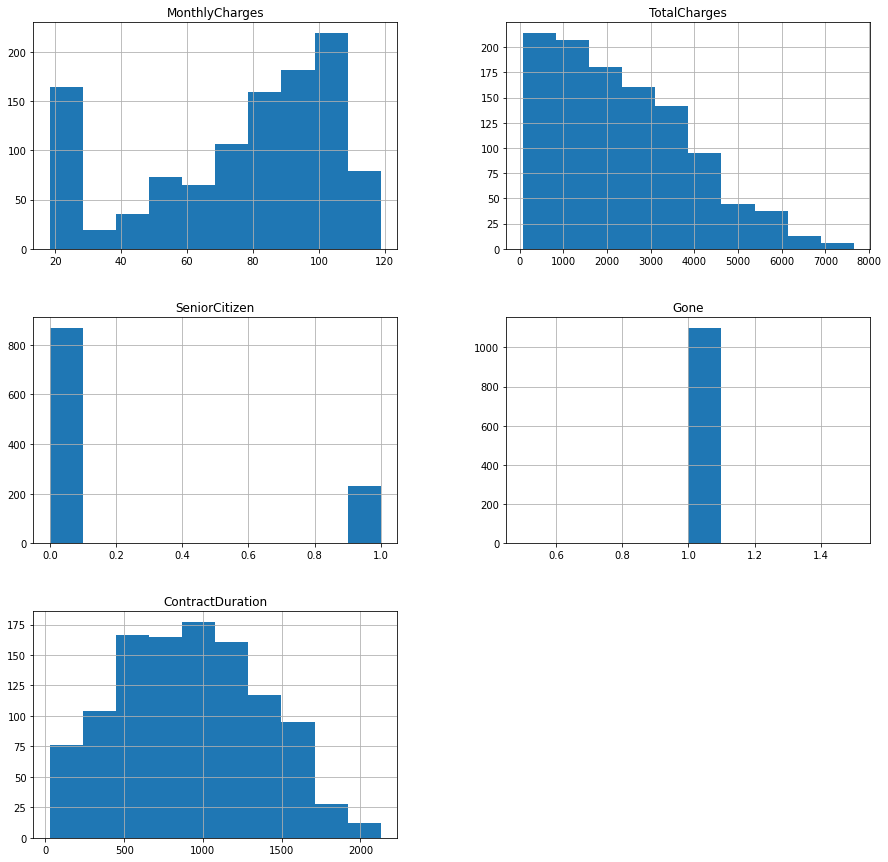

In [ ]:
data_inactive = data.query('Gone == 1')
data_inactive.hist(figsize=(15, 15));

Здесь ситуация изменилась. На графиках видно, что относительное количество ушедших пенсионеров больше относительного количества действующих.

Средний ежемесячный платёж также выше у тех, кто уходит, как и среднее общее количество потраченных денег на услуги. Продолжительность контракта ушедших в основном от 500 до 1500 дней - в этом диапазоне мы видим провал среди действующих клиентов. Это говорит о том, что оператор связи делает недостаточно для удержания своих среднесрочных клиентов.

Предположительно различные привилегии доступны только для очень давних клиентов и для новых. Поэтому пользователи со сроком 2-4 года отказываются от услуг в пользу конкурентов

Рассмотрим поближе различия ежемесячных платежей в зависимости от того, ушедший пользователь или нет

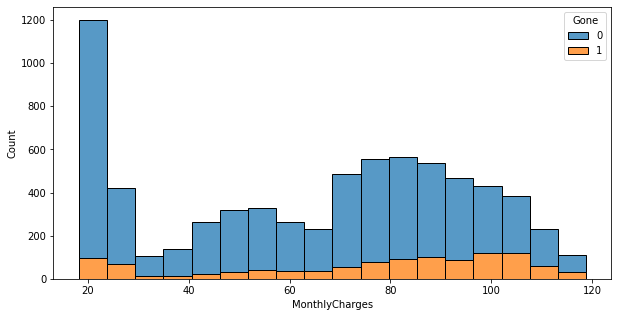

In [ ]:
plt.figure(figsize=(10, 5))
fig = sns.histplot(data, x='MonthlyCharges', hue='Gone', multiple="stack")
plt.show()

Ушедшие клиенты в среднем платят больше

Посмотрим на общее количество платежей

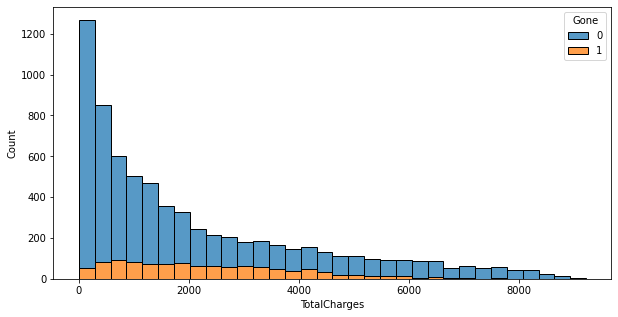

In [ ]:
plt.figure(figsize=(10, 5))
fig = sns.histplot(data, x='TotalCharges', hue='Gone', multiple="stack")
plt.show()

Видно смещение доли ушедших клиентов в правую сторону, значит в среднем они платили больше

Обратим внимание на длительность контракта

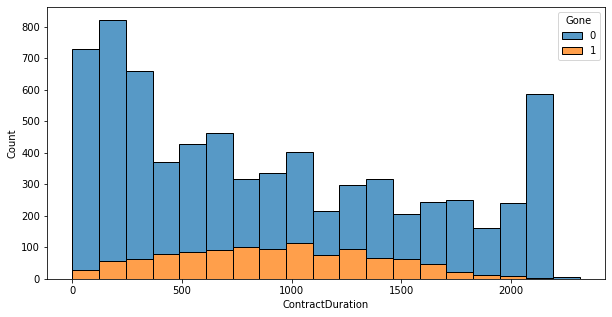

In [ ]:
plt.figure(figsize=(10, 5))
fig = sns.histplot(data, x='ContractDuration', hue='Gone', multiple="stack")
plt.show()

Видим, что основная часть ушедших пользователей сосредоточена там, где среди активных есть провал. Значит компания теряет среднесрочных пользователей

### Взаимосвязь признаков

Чтобы определить, действительно ли все признаки имеют значение для целевого признака, а также же их мультиколлинеарность, построим матрицу корреляции с помощью библиотеки phik, которая принимает и численные, и категориальные признаки и находит взаимосвязь между ними

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Gone', 'ContractDuration']


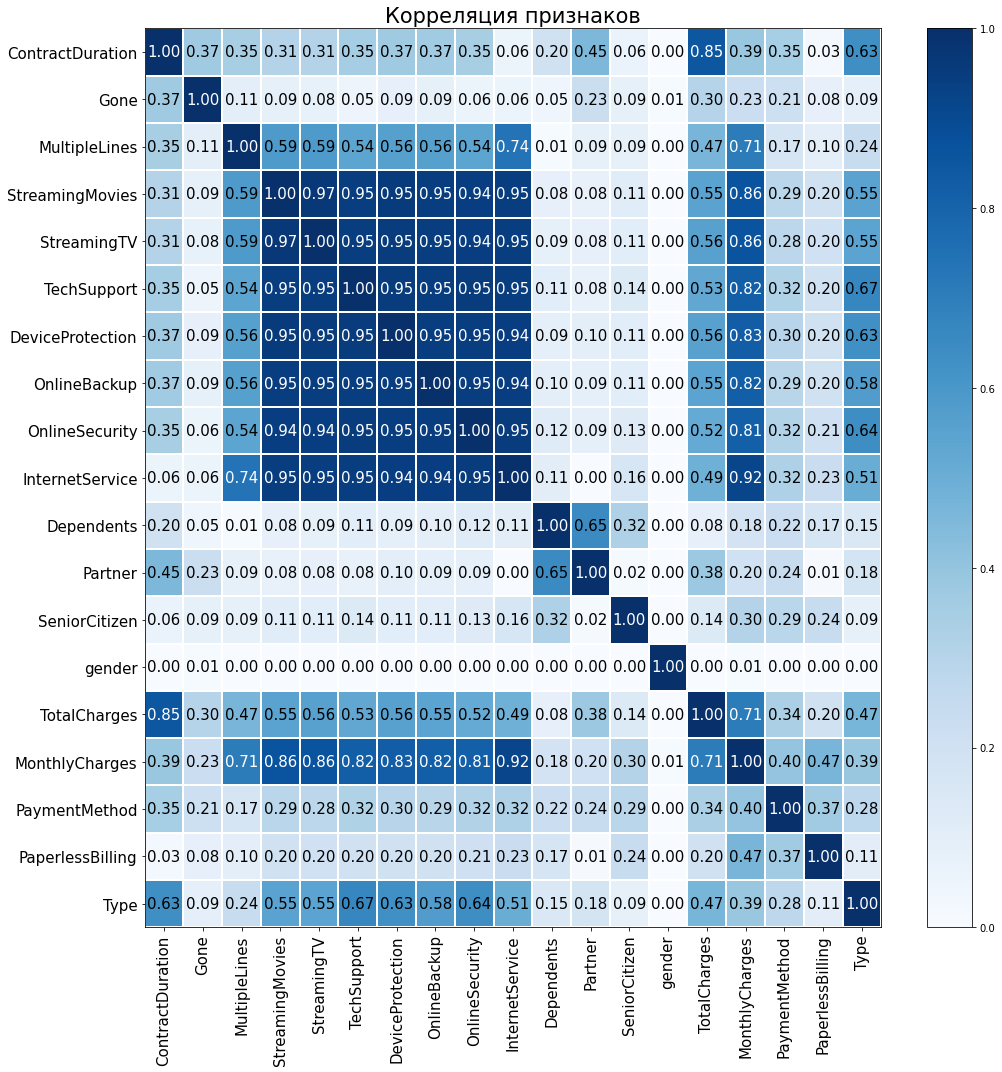

In [ ]:
phik_matrix = data.phik_matrix()

plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'Корреляция признаков', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()

На матрице видим, что столбец Gender практически не имеет взаимосвязи с другими признаками, а значит он не имеет смысла, и его можно удалить.

Обратим внимание на очень связанные между собой признаки, которые объединяют в себе услугу пользования интернетом. В данном случае это не означает мультиколлинеарность, так как по сути пользователь покупает пакетом эту услугу, поэтому взаимосвязь признаков логична и не скажется отрицательно на работе модели.

Также отметим, что синтетический признак длительности контракта имеет наибольшее влияние на целевой признак, что поможет более точно определять уход клиента будущей модели

In [ ]:
data = data.drop(['gender'], axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Gone,ContractDuration
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Вывод: в ходе анализа мы выяснили, что большинство уходящих клиентов имеют срок контракта примерно от 2 до 4 лет, при этом уходящие клиенты в среднем больше платят ежемесячно и имеют в среднем большее итоговое значение платежей.

Самым не взаимосвязанным с другими признаком оказался пол пользователя, а самым влияющим на целевую переменную - созданный нами признак длительности контракта.

Таким образом, теперь мы имеем представление об уходящем клиенте и знаем, какие из имеющихся у нас признаков в значительной степени коррелируют с его уходом

## Обучение моделей

### Выделение выборок

Разделим наш датасет на целевой признак и остальные признаки. В свою очередь их разделим на обучающую и тестовую выборки, отделив на тест четвёртую часть данных

In [ ]:
features = data.drop(['Gone'], axis=1)
target = data['Gone']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            stratify=target, random_state=RANDOM_STATE)

### Кодирование данных

Выделим категориальные признаки и закодируем в численные с помощью техники прямого кодирования, избегая дамми-ловушки

In [ ]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train[ohe_features])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

features_train = features_train.drop(ohe_features, axis=1)

### Обучение моделей

In [ ]:
params = {
    'max_depth': range(1, 4),
    'n_estimators': range(10, 31, 10)
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE,
                                                       class_weight='balanced'), params, cv=5, scoring='roc_auc')
rf_model.fit(features_train, target_train)

print('ROC-AUC score случайного леса:', rf_model.best_score_)
print('Лучшие параметры:', rf_model.best_params_)

ROC-AUC score случайного леса: 0.7925880124146896
Лучшие параметры: {'max_depth': 3, 'n_estimators': 30}


In [ ]:
params = {
    'max_depth': range(1, 7),
}
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                       class_weight='balanced'), params, cv=5, scoring='roc_auc')
dt_model.fit(features_train, target_train)

print('ROC-AUC score решающего деерва:', dt_model.best_score_)
print('Лучшие параметры:', dt_model.best_params_)

ROC-AUC score решающего деерва: 0.7837589262203087
Лучшие параметры: {'max_depth': 6}


Для модели Catboost не нужно кодировать данные, поэтому переназначим переменные для выборок и передадим данные в оригинальном виде

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            stratify=target, random_state=RANDOM_STATE)

params = {
    'max_depth': range(1, 3),
    'n_estimators': range(450, 501, 10),
    'learning_rate': np.arange(0.5, 0.7, 0.1)
}
cat_model = GridSearchCV(CatBoostClassifier(random_state=RANDOM_STATE, verbose=False,
                                           cat_features=features_train.select_dtypes(include='object').columns.to_list()),
                                           params, cv=5, scoring='roc_auc')
cat_model.fit(features_train, target_train)

print('ROC-AUC score Catboost:', cat_model.best_score_)
print('Лучшие параметры:', cat_model.best_params_)

ROC-AUC score Catboost: 0.9280110743680746
Лучшие параметры: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 450}


Вывод: в этом разделе мы разделили выборки для обучения и теста, закодировали данные для моделей с деревьями, обучили несколько моделей и получили отличные результаты на одной из них.

Этой моделью оказался градиентный бустинг CatBoost c параметрами learning_rate=0.5, max_depth=2, n_estimators=450.

Таким образом, теперь мы можем протестировать модель и заодно узнаем её точность по метрике accuracy

## Тестирование лучшей модели

Используем лучшие подобранные гиперпараметры Catboost для тестирования

In [ ]:
model = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE,
                           learning_rate=0.5, max_depth=2, n_estimators=450,
                           cat_features=features_train.select_dtypes(include='object').columns.to_list())
cat_model = model.fit(features_train, target_train)
predict_prob = model.predict_proba(features_test)
probabilities = predict_prob[:, 1]
roc_auc = roc_auc_score(target_test, probabilities)
accuracy = accuracy_score(target_test, model.predict(features_test))

print('ROC-AUC score CatBoost на тестовой выборке:', roc_auc)
print('Accuracy score CatBoost на тестовой выборке:', accuracy)

ROC-AUC score CatBoost на тестовой выборке: 0.9287544353358621
Accuracy score CatBoost на тестовой выборке: 0.9312890403180011


Построим график ROC кривой

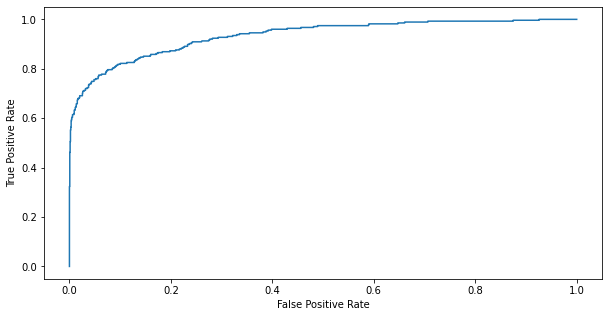

In [ ]:
fpr, tpr, _ = roc_curve(target_test, probabilities)

plt.figure(figsize=(10, 5))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Наша модель показывает хороший уровен истинно положительных ответов, а значит хорошо классифицирует данные по категориям

В конце оценим, какой из признаков оказался наиболее важным для нашей лучшей модели

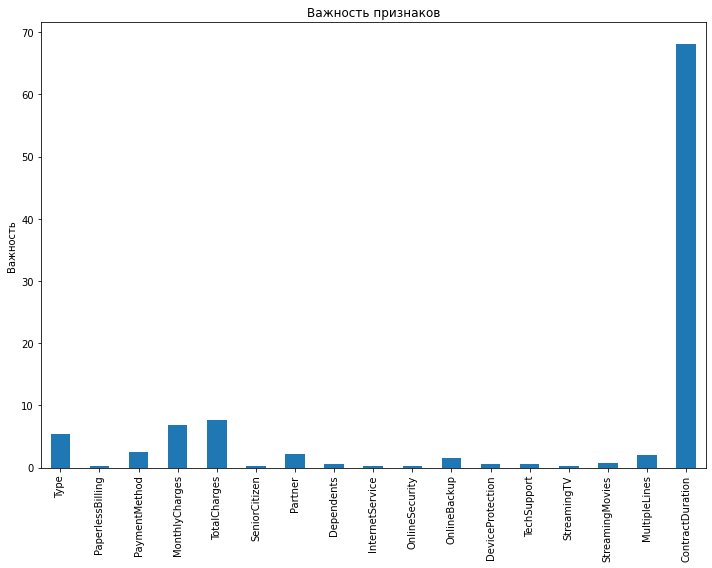

In [ ]:
model_feat_imp = pd.Series(cat_model.feature_importances_,
                         features.columns)

fig, ax = plt.subplots(figsize=(10, 8))
model_feat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Видим, что наиболее важным признаком оказался синтетический признак длительности контракта

Итого мы получили хорошие значения метрики ROC-AUC, необходимые для запуска модели, а также оценили её точность.

Модель на 93% верно будет определять класс клиентов, а значит у оператора связи есть хорошая опора для удержания своих пользователей

# Отчёт по работе

Все шаги, проделанные в проекте, совпадают с планом

Затруднения возникли с интеграцией кодировщика OHE в Pipeline, поэтому было принято решение вынести кодирование данных отдельно

Одним из ключевых шагов, повлиявших на достижение высокого значения метрики ROC-AUC, стало создание синтетического признака длительности контракта на основе двух оригинальных признаков с датами начала и окончания(выгрузки) контракта

Модель машинного обучения - CatBoostClassifier. Гиперпараметры: learning_rate=0.5, max_depth=2, n_estimators=500

RANDOM_STATE = 310723

Размер тестовой выборки: 25% от общего датасета (1761 строка, 17 столбцов)

Метрика ROC-AUC на тестовой выборке: 0.9287544353358621

При обучении использовались признаки:

  - Type – тип оплаты: ежемесячный, годовой и тд

  - PaperlessBilling – безналичный расчет

  - PaymentMethod – способ оплаты

  - MonthlyCharges – ежемесячные траты на услуги

  - TotalCharges – всего потрачено денег на услуги

  - Dependents – наличие иждивенцев

  - Senior Citizen – наличие пенсионного статуса по возрасту

  - MultipleLines – наличие возможности ведения параллельных линий во время звонка

  - ContractDuration - длительность контракта

  - Услуги интернета: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

Сгенерирован признак ContractDuration на основе признаков BeginDate и EndDate, а также даты выгрузки данных

Предобработка данных происходила в несколько этапов:

1. Были объединены датасеты. С данными о персональных и информацией по договору - типом inner, с остальными - left.
2. Был изменён тип данных столбца с общим количеством платежей на численный.
3. Были обработаны пропуски, образовавшиеся в ходе изменения типа данных этого столбца (заполнены нулём), а также при объединении датасетов (по категориям 'не пользуются интернетом' или 'не пользуются телефоном'.
4. Были созданы новые признаки: целевой признак Gone из столбца EndDate, который сообщает нам, ушедший клиент или активный, а также синтетический признак ContractDuration, который даёт информацию о длительности контракта пользователя. Признаки BeginDate и EndDate были удалены во избежание утечки данных в модель.